**Progetto: Filtro per Fake News.**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]

import string
import re
import spacy
nlp = spacy.load("en_core_web_sm")

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
en_stopwords = stopwords.words("english")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import pickle

def data_clear(data):
    """
    Pulizia di un testo, restituisce una lista con parole nella loro forma canonica.
    """
    dataset_cleared = []
    for phrase in data:
        phrase = phrase.lower()
        for i in string.punctuation:
            if i in phrase:
                phrase = phrase.replace(i, " ")

        phrase = re.sub("\d", "", phrase)
        phrase = " ".join(word for word in phrase.split() if word not in en_stopwords)
        phrase = " ".join(token.lemma_ for token in nlp(phrase))
        dataset_cleared.append(phrase)

    return dataset_cleared

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
!unzip fake_news.zip

--2024-05-22 10:22:05--  https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.155.82, 3.5.224.12
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.155.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42975911 (41M) [application/zip]
Saving to: ‘fake_news.zip.1’

fake_news.zip.1     100%[===================>]  40.98M  3.77MB/s    in 16s     

2024-05-22 10:22:22 (2.51 MB/s) - ‘fake_news.zip.1’ saved [42975911/42975911]

Archive:  fake_news.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Dataset notizie attendibili.

La feature "date" non viene caricata in quanto considerata poco informativa per lo scopo dell'addestramento del modello.

In [ ]:
df_true = pd.read_csv("True.csv", usecols=[0, 1, 2])
df_true.head()

,title,text,subject
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews


Dataset notizie false.

In [ ]:
df_fake = pd.read_csv("Fake.csv", usecols=[0, 1, 2])
df_fake.head()

,title,text,subject
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News


Panoramica sui dati.

In [ ]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
dtypes: object(3)
memory usage: 550.5+ KB


In [ ]:
df_fake.describe()

,title,text,subject
count,23481,23481,23481
unique,17903,17455,6
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News
freq,6,626,9050


*Analisi statistiche.*

**Quesito:**

le fake news sono più frequenti in una determinata categoria?

Utilizzo del metodo value_counts() per determinare le frequenze di ogni record nella feature "subject" (le diverse categorie delle notizie).

In [ ]:
df_fake["subject"].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

Costruzione di un grafico a barre per la visualizzazione dei risultati dell'analisi statistica.

Gli articolo contenenti fake news riguardano maggiormente la categoria News.

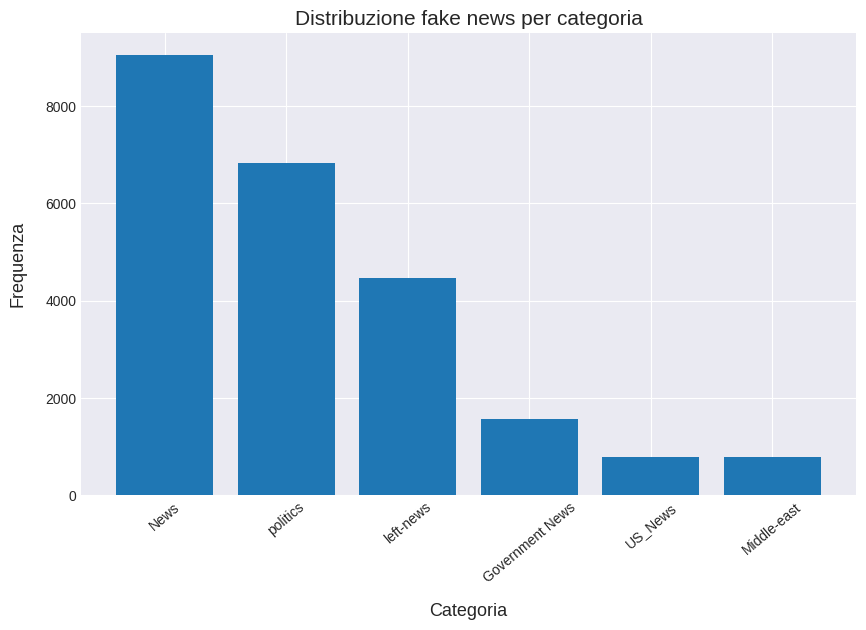

In [ ]:
fake_freq = df_fake["subject"].value_counts()

x = fake_freq.index
y = fake_freq

plt.bar(x, y)

plt.title("Distribuzione fake news per categoria", size=15)
plt.xlabel("Categoria", labelpad=13, size=13)
plt.ylabel("Frequenza", labelpad=13, size=13)
plt.xticks(rotation=40);

**Quesito:**

per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?

Partendo dal presupposto che il titolo del testo sia il veicolo maggiormente informativo per capire l'argomento del testo stesso, nel seguente codice si procede con il raggruppamento dei record (notizie false) per la feature "subject" (categoria) con il metodo groupby(), di seguito viene calcolata la frequenza dei record della feature "title" cosi raggruppati, il risultato è organizzato in una nuova feature denominata "occurrence".

il dataset viene ordinato con il metodo sort_values in ordine decrescente secondo "occurrence".

Infine viene utilizzata una maschera booleana che restituisce i valori True che rispettano la condizone, gli stessi sono gli unici ad essere visualizzati.

In [ ]:
occurrence_column = df_fake.groupby(["subject"])["title"].value_counts().reset_index(name="occurrence")

occurrence = occurrence_column.sort_values(by="occurrence", ascending=False)

occurrence_subject = occurrence.loc[occurrence.groupby('subject')['occurrence'].idxmax()]

Da un'analisi che considera esclusivamente il titolo, l'argomento maggiormente soggetto alle fake news sia per la categoria "politics" che "left-news" riguarda Bill Clinton.

In [ ]:
occurrence_subject

,subject,title,occurrence
0,Government News,#CongressionalBaseballGame Shooter Identified:...,1
2200,Middle-east,Henningsen on Trump Rally Fervor: ‘Political R...,1
2348,News,McConnell Says He’ll Obstruct ANY Effort To H...,2
11986,US_News,Episode #153 – SUNDAY WIRE: ‘The Nuremberg Syn...,1
12180,left-news,MEDIA IGNORES Time That Bill Clinton FIRED His...,3
16635,politics,MEDIA IGNORES Time That Bill Clinton FIRED His...,3


In [ ]:
occurrence_subject.max()[1]

'MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead'

*Addestramento del modello di classificazione.*

In [ ]:
data_true = df_true.copy()
data_fake = df_fake.copy()

Il modello di classificazione NLP, essendo un modello di machine learning semi-supervisionato, necessità di un target a cui attribuire i dati d'esempio con i quali viene addestrato.

Di conseguenza la feature "subject" ritenuta non informativa per gli scopi proposti viene trasformata nel valore intero 1 per il dataset di esempi veritieri e nel valore intero 0 per il dataset di esempi falsi con il metodo apply(), il nome della feature viene modificato in "target" e la feature "title" viene eliminata.

In [ ]:
data_true["subject"] = data_true["subject"].apply(lambda x: x if x == "real" else 1)
data_fake["subject"] = data_fake["subject"].apply(lambda x: x if x == "fake" else 0)

In [ ]:
data_true.rename(columns={"subject": "target"}, inplace=True)
data_fake.rename(columns={"subject": "target"}, inplace=True)

In [ ]:
data_true = data_true.drop("title", axis=1)
data_fake = data_fake.drop("title", axis=1)

In [ ]:
len(data_true)

21417

In [ ]:
len(data_fake)

23481

Al fine di ottenere un unico dataset per l'addestramento, i dataset parziali "data_ture" e "data_fake" vengono uniti per feature con il metodo concat().

In [ ]:
dataset = pd.concat([data_true, data_fake], axis=0)
dataset

,text,target
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,0
23477,21st Century Wire says It s a familiar theme. ...,0
23478,Patrick Henningsen 21st Century WireRemember ...,0
23479,21st Century Wire says Al Jazeera America will...,0


In [ ]:
len(dataset[dataset["target"] == 1])

21417

In [ ]:
len(dataset[dataset["target"] == 0])

23481

Verifica della distribuzione dei dati per categoria (balance).

In [ ]:
Real = len(dataset[dataset["target"] == 1]) / (len(dataset[dataset["target"] == 1]) + len(dataset[dataset["target"] == 0]))*100
Fake = len(dataset[dataset["target"] == 0]) / (len(dataset[dataset["target"] == 1]) + len(dataset[dataset["target"] == 0]))*100

In [ ]:
print(f"Features appartenenti alla categoria Real: {Real:0.2f}")
print(f"Features appartenenti alla categoria Fake: {Fake:0.2f}")

Features appartenenti alla categoria Real: 47.70
Features appartenenti alla categoria Fake: 52.30


Divisione del dataset in train e test per verificare la presenza di overfitting.

In [ ]:
X = dataset["text"]
y = dataset["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Pulizia del dataset con la funzione data_clear che restituirà le parole nella loro forma canonica.

In [ ]:
X_train = data_clear(X_train)
X_test = data_clear(X_test)

Trasformazione di dati semi-strutturati in dati strutturati che vengono trasformati in matrice.

In [ ]:
tfidfv = TfidfVectorizer()

X_train = tfidfv.fit_transform(X_train)
X_train = X_train.toarray()

X_test = tfidfv.transform(X_test)
X_test = X_test.toarray()

Standardizzazione dei dati con "with_mean=False" per mantenere i dati in una matrice sparsa di zeri e limitando il consumo di memoria.

In [ ]:
ss = StandardScaler(with_mean=False)

X_train = ss.fit_transform(X_train)
X_test =  ss.transform(X_test)

Ottimizzazione dell'iper-parametro "hidden_layer_sizes", con un solo layer.

In [ ]:
for size in [100, 200, 400, 600, 800, 1000]:
    clf = MLPClassifier(activation="logistic",
                        hidden_layer_sizes=(size,),
                        max_iter=100,
                        solver="adam",
                        tol=0.005,
                        verbose=True)

    clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)
    print(f"Accuratezza con {size} hidden_layer: {score}")

Addestramento del modello di classificazione con MLPClassifier con il miglior iper-parametro.

In [ ]:
clf = MLPClassifier(activation="logistic",
                    hidden_layer_sizes=(600,),
                    max_iter=100,
                    solver="adam",
                    tol=0.005,
                    verbose=True)

clf.fit(X_train, y_train)

Metriche per verficare la bontà del modello.

Viene utilizzata l'accurancy che esprime in percentuale la quantità di stime corrette eseguite dal modello, quindi l'attribuzione di una serie di dati al target richiesto, rispetto ai casi reali in cui quei dati sono effettivamente associati.

In [ ]:
clf.score(X_test, y_test)

Esportazione del modello su file per renderlo permanente.

In [ ]:
with open("filtro fake news.pkl", "wb") as file:
    pickle.dump(clf, file)